# CURVE AB

This notebook is set up for data analysis and research.



```
P(s) = (X, Y, Z) = (
    L_A * s,          # X轴：线性化的A曲线长度
    x_B(t(s)),        # Y轴：B曲线x坐标
    y_B(t(s))         # Z轴：B曲线y坐标
)
```

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from svg.path import parse_path
from svg.path.path import Line, CubicBezier

# INPUT

# 输入曲线数据
A_d = "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5"
B_d = "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"

def parse_svg_path(d):
    """解析SVG路径为贝塞尔曲线段
    
    Args:
        d (str): SVG路径字符串
    
    Returns:
        list: 包含曲线段信息的字典列表
    """
    path = parse_path(d)
    segments = []
    for e in path:
        if isinstance(e, CubicBezier):
            segments.append({
                'start': (e.start.real, e.start.imag),
                'c1': (e.control1.real, e.control1.imag),
                'c2': (e.control2.real, e.control2.imag),
                'end': (e.end.real, e.end.imag)
            })
        elif isinstance(e, Line):
            segments.append({
                'start': (e.start.real, e.start.imag),
                'end': (e.end.real, e.end.imag)
            })
    return segments


def bezier_sample(segments, n_samples=50):
    """采样贝塞尔曲线
    
    Args:
        segments (list): 曲线段列表
        n_samples (int): 每段曲线的采样点数
    
    Returns:
        np.array: 采样点数组，形状为 (n_points, 2)
    """
    points = []
    for seg in segments:
        if 'c1' in seg:  # 三次贝塞尔曲线
            t = np.linspace(0, 1, n_samples)
            x = (1-t)**3*seg['start'][0] + 3*(1-t)**2*t*seg['c1'][0] + 3*(1-t)*t**2*seg['c2'][0] + t**3*seg['end'][0]
            y = (1-t)**3*seg['start'][1] + 3*(1-t)**2*t*seg['c1'][1] + 3*(1-t)*t**2*seg['c2'][1] + t**3*seg['end'][1]
            points.extend(list(zip(x, y)))
        else:  # 直线段
            x = np.linspace(seg['start'][0], seg['end'][0], n_samples)
            y = np.linspace(seg['start'][1], seg['end'][1], n_samples)
            points.extend(list(zip(x, y)))
    return np.array(points)

In [14]:
def plot_bezier_curves(A_points, B_points, A_segments, B_segments):
    """绘制贝塞尔曲线及其控制点
    
    Args:
        A_points (np.array): A曲线的采样点
        B_points (np.array): B曲线的采样点
        A_segments (list): A曲线的段信息
        B_segments (list): B曲线的段信息
    """
    plt.figure(figsize=(12, 8))
    
    # 绘制曲线和采样点
    plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', label='Curve A', linewidth=1, alpha=0.5)
    plt.scatter(A_points[:, 0], -A_points[:, 1], c='blue', s=20, alpha=0.5, label='A Points')
    
    plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', label='Curve B', linewidth=1, alpha=0.5)
    plt.scatter(B_points[:, 0], -B_points[:, 1], c='red', s=20, alpha=0.5, label='B Points')
    
    # 绘制控制点
    for seg in A_segments:
        if 'c1' in seg:
            plt.plot(seg['start'][0], -seg['start'][1], 'bo', markersize=10, alpha=0.7)
            plt.plot(seg['c1'][0], -seg['c1'][1], 'bx', markersize=10, alpha=0.7)
            plt.plot(seg['c2'][0], -seg['c2'][1], 'bx', markersize=10, alpha=0.7)
            plt.plot(seg['end'][0], -seg['end'][1], 'bo', markersize=10, alpha=0.7)
    
    for seg in B_segments:
        if 'c1' in seg:
            plt.plot(seg['start'][0], -seg['start'][1], 'ro', markersize=10, alpha=0.7)
            plt.plot(seg['c1'][0], -seg['c1'][1], 'rx', markersize=10, alpha=0.7)
            plt.plot(seg['c2'][0], -seg['c2'][1], 'rx', markersize=10, alpha=0.7)
            plt.plot(seg['end'][0], -seg['end'][1], 'ro', markersize=10, alpha=0.7)
    
    plt.grid(True)
    plt.legend()
    plt.title('Bezier Curves with Sampling Points')
    plt.axis('equal')
    plt.xlim(-10, 190)
    plt.ylim(-70, 10)
    plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


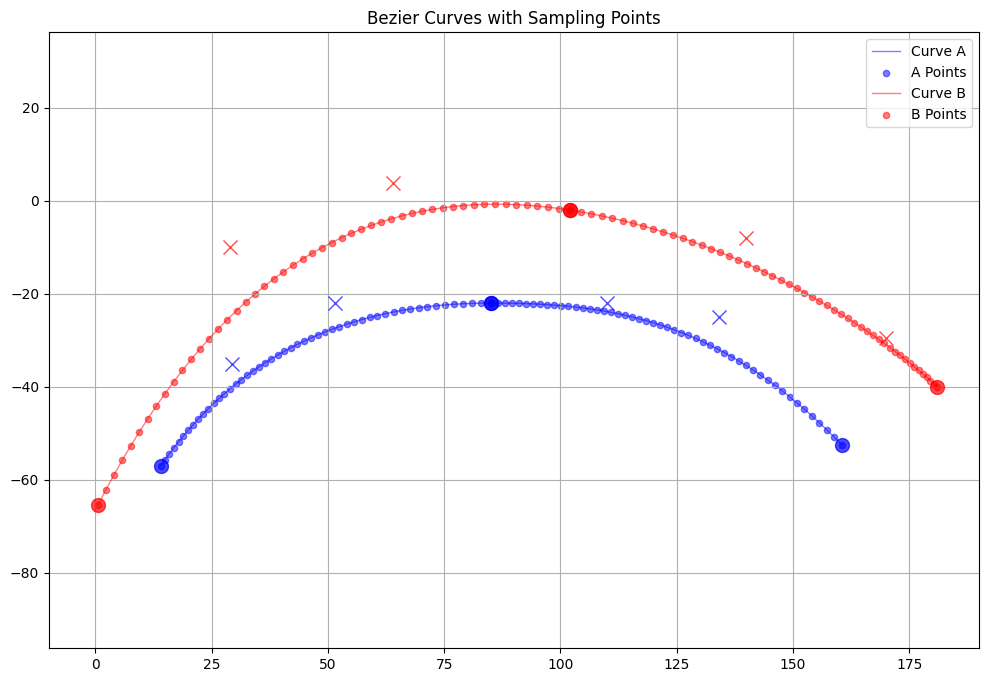

In [15]:
# 解析SVG路径
A_segments = parse_svg_path(A_d)
B_segments = parse_svg_path(B_d)

# 采样曲线
A_points = bezier_sample(A_segments, n_samples=50)
B_points = bezier_sample(B_segments, n_samples=50)

# 绘制曲线
plot_bezier_curves(A_points, B_points, A_segments, B_segments)

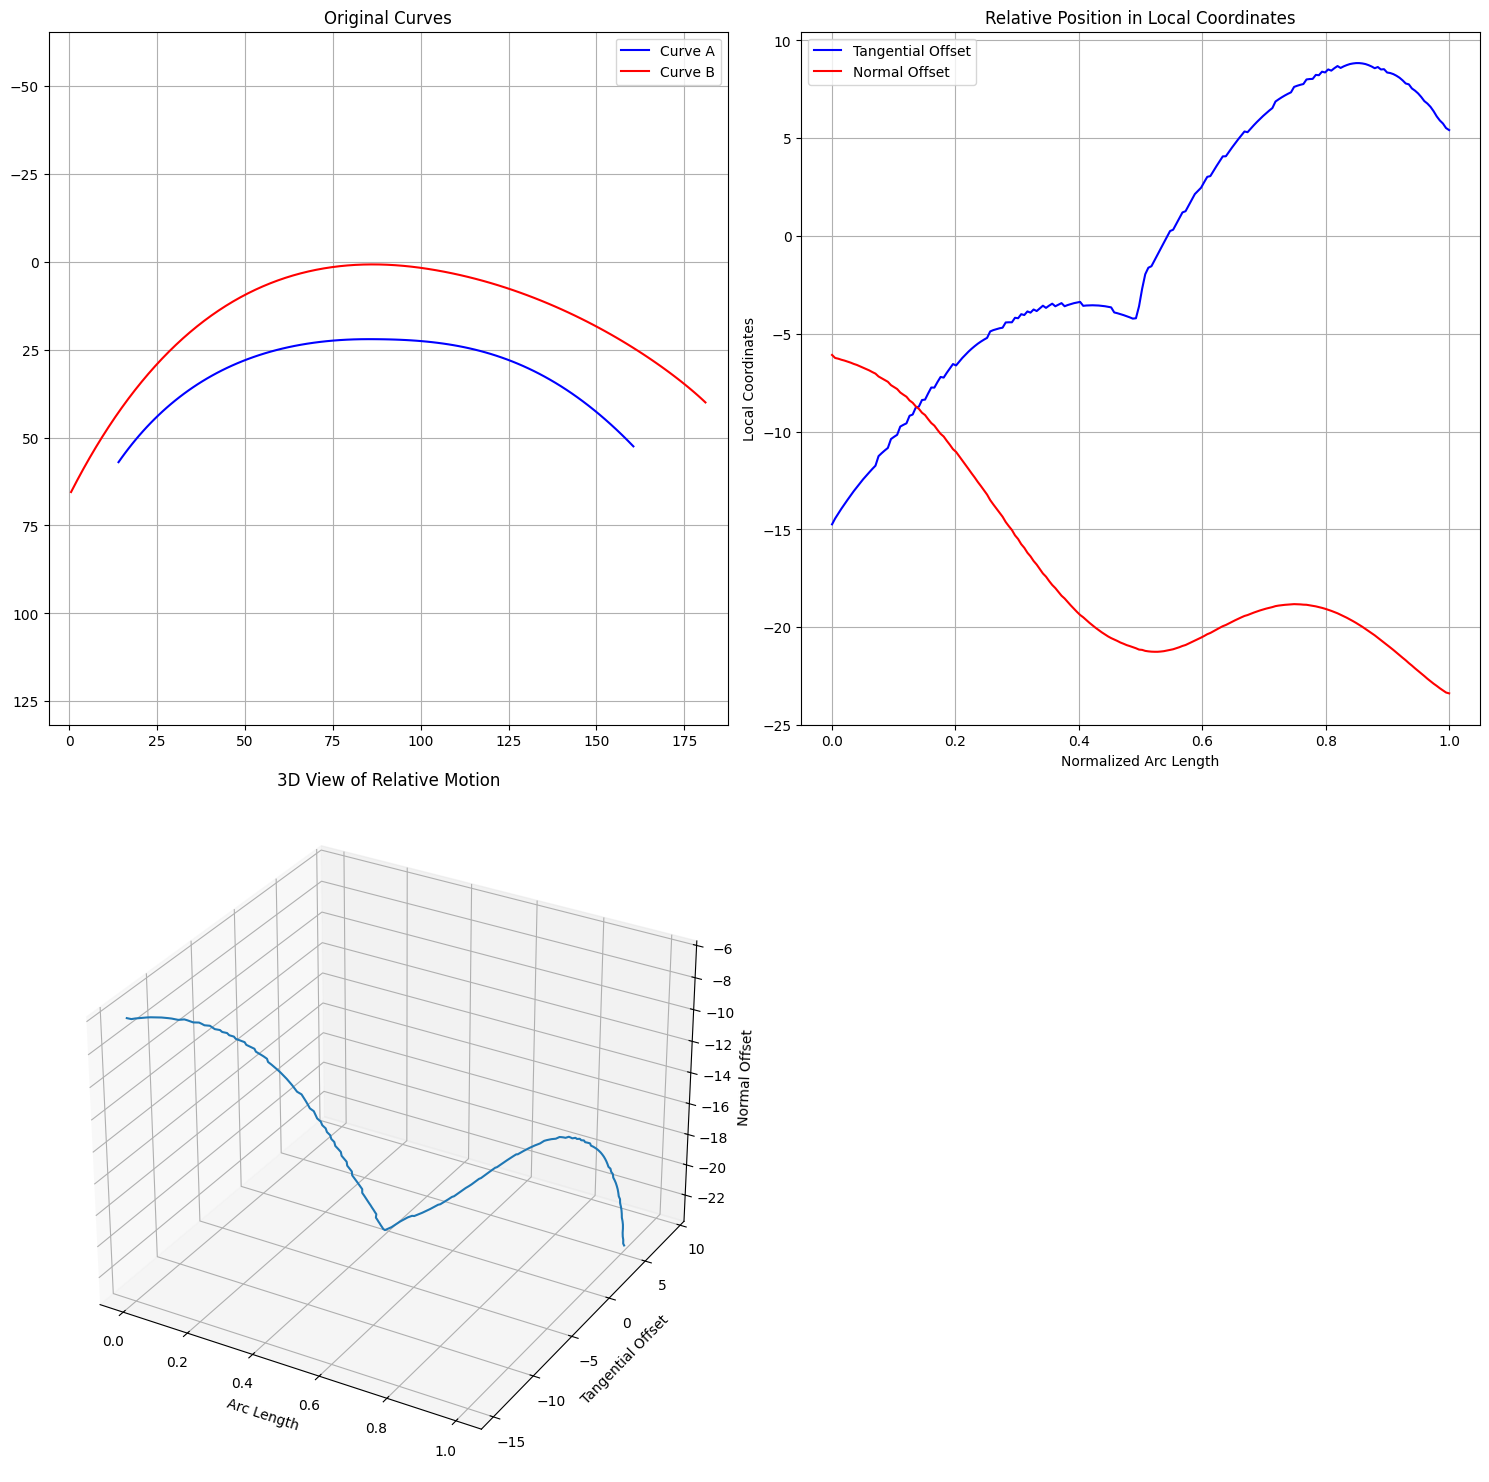

In [16]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def arc_length_parameterization(points):
    """弧长参数化"""
    dx = np.diff(points[:,0])
    dy = np.diff(points[:,1])
    seg_lengths = np.sqrt(dx**2 + dy**2)
    cum_length = np.cumsum(seg_lengths)
    total_length = cum_length[-1]
    normalized = np.insert(cum_length, 0, 0) / total_length
    return normalized, total_length

def compute_tangent_normal(points):
    """计算曲线的切向量和法向量"""
    # 计算切向量
    dx = np.gradient(points[:,0])
    dy = np.gradient(points[:,1])
    
    # 归一化切向量
    lengths = np.sqrt(dx**2 + dy**2)
    tangent = np.column_stack([dx/lengths, dy/lengths])
    
    # 计算法向量 (切向量逆时针旋转90度)
    normal = np.column_stack([-tangent[:,1], tangent[:,0]])
    
    return tangent, normal

def transform_to_local_coordinates(point, origin, tangent, normal):
    """将点转换到局部坐标系"""
    # 将点平移到原点
    translated = point - origin
    
    # 投影到切向和法向方向
    x_local = np.dot(translated, tangent)
    y_local = np.dot(translated, normal)
    
    return np.array([x_local, y_local])

# 假设 A_points 和 B_points 已经定义

# 计算曲线A的弧长参数化和局部坐标系
s_A, L_A = arc_length_parameterization(A_points)
tangent_A, normal_A = compute_tangent_normal(A_points)

# 为曲线B创建更密集的采样点
num_samples = 1000
t_dense = np.linspace(0, 1, num_samples)
B_dense = np.column_stack([
    np.interp(t_dense, np.linspace(0, 1, len(B_points)), B_points[:,0]),
    np.interp(t_dense, np.linspace(0, 1, len(B_points)), B_points[:,1])
])

# 计算密集采样点的弧长参数化
s_B_dense, _ = arc_length_parameterization(B_dense)

# 对曲线A选择采样点
num_A_samples = 200
s_values = np.linspace(0, 1, num_A_samples)
A_sampled = np.column_stack([
    np.interp(s_values, np.linspace(0, 1, len(A_points)), A_points[:,0]),
    np.interp(s_values, np.linspace(0, 1, len(A_points)), A_points[:,1])
])

# 计算采样点的切向量和法向量
tangent_sampled, normal_sampled = compute_tangent_normal(A_sampled)

# 对每个曲线A的采样点，找到对应的曲线B点并转换到局部坐标系
local_coordinates = []
for i in range(len(s_values)):
    # 找到对应的曲线B点
    idx = np.argmin(np.abs(s_B_dense - s_values[i]))
    B_point = B_dense[idx]
    
    # 转换到局部坐标系
    local_coord = transform_to_local_coordinates(
        B_point, 
        A_sampled[i], 
        tangent_sampled[i], 
        normal_sampled[i]
    )
    local_coordinates.append(local_coord)

local_coordinates = np.array(local_coordinates)

# 绘制结果
fig = plt.figure(figsize=(15, 15))

# 原始曲线
ax1 = fig.add_subplot(221)
ax1.plot(A_points[:,0], A_points[:,1], 'b-', label='Curve A')
ax1.plot(B_points[:,0], B_points[:,1], 'r-', label='Curve B')
ax1.set_title('Original Curves')
ax1.grid(True)
ax1.legend()
ax1.axis('equal')
ax1.invert_yaxis()

# 相对关系图
ax2 = fig.add_subplot(222)
ax2.plot(s_values, local_coordinates[:,0], 'b-', label='Tangential Offset')
ax2.plot(s_values, local_coordinates[:,1], 'r-', label='Normal Offset')
ax2.set_xlabel('Normalized Arc Length')
ax2.set_ylabel('Local Coordinates')
ax2.set_title('Relative Position in Local Coordinates')
ax2.grid(True)
ax2.legend()

# 3D视图
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(s_values, local_coordinates[:,0], local_coordinates[:,1])
ax3.set_xlabel('Arc Length')
ax3.set_ylabel('Tangential Offset')
ax3.set_zlabel('Normal Offset')
ax3.set_title('3D View of Relative Motion')

plt.tight_layout()
plt.show()

# 曲线相对位置分析说明

## 视图说明

这段代码生成了三个视图，用于分析两条曲线（曲线A和曲线B）之间的相对位置关系：

### 1. 原始曲线视图（左上）

- 显示两条曲线在原始坐标系中的形状
- 蓝色线表示曲线A
- 红色线表示曲线B
- 这个视图帮助我们直观理解两条曲线的空间关系

### 2. 相对关系图（右上）

- X轴：表示曲线A的标准化弧长参数（0到1）
- 蓝线：表示切向偏移量（前后方向的距离）
- 红线：表示法向偏移量（左右方向的距离）
- 这个视图帮助我们理解在曲线A的每个位置，曲线B相对于它的偏移情况

### 3. 3D相对运动视图（左下）

- X轴：曲线A的标准化弧长参数（0到1）
- Y轴：切向偏移量（表示曲线B相对于曲线A的前后位置）
  - 正值：B在A的前方
  - 负值：B在A的后方
- Z轴：法向偏移量（表示曲线B相对于曲线A的左右位置）
  - 正值：B在A的左侧
  - 负值：B在A的右侧

这个3D视图将两个偏移量组合在一起，形成了一条空间曲线，帮助我们理解：
1. 曲线B如何随着曲线A的推进而变化位置
2. 两条曲线之间的相对运动关系
3. 在曲线A的每个位置，曲线B的相对偏移状态

## 应用场景

这种分析方法在以下场景特别有用：
- 机器人路径规划中的跟随行为分析
- 两个物体之间的相对运动分析
- 舞蹈编排中的双人动作设计
- 工业自动化中的协同运动控制


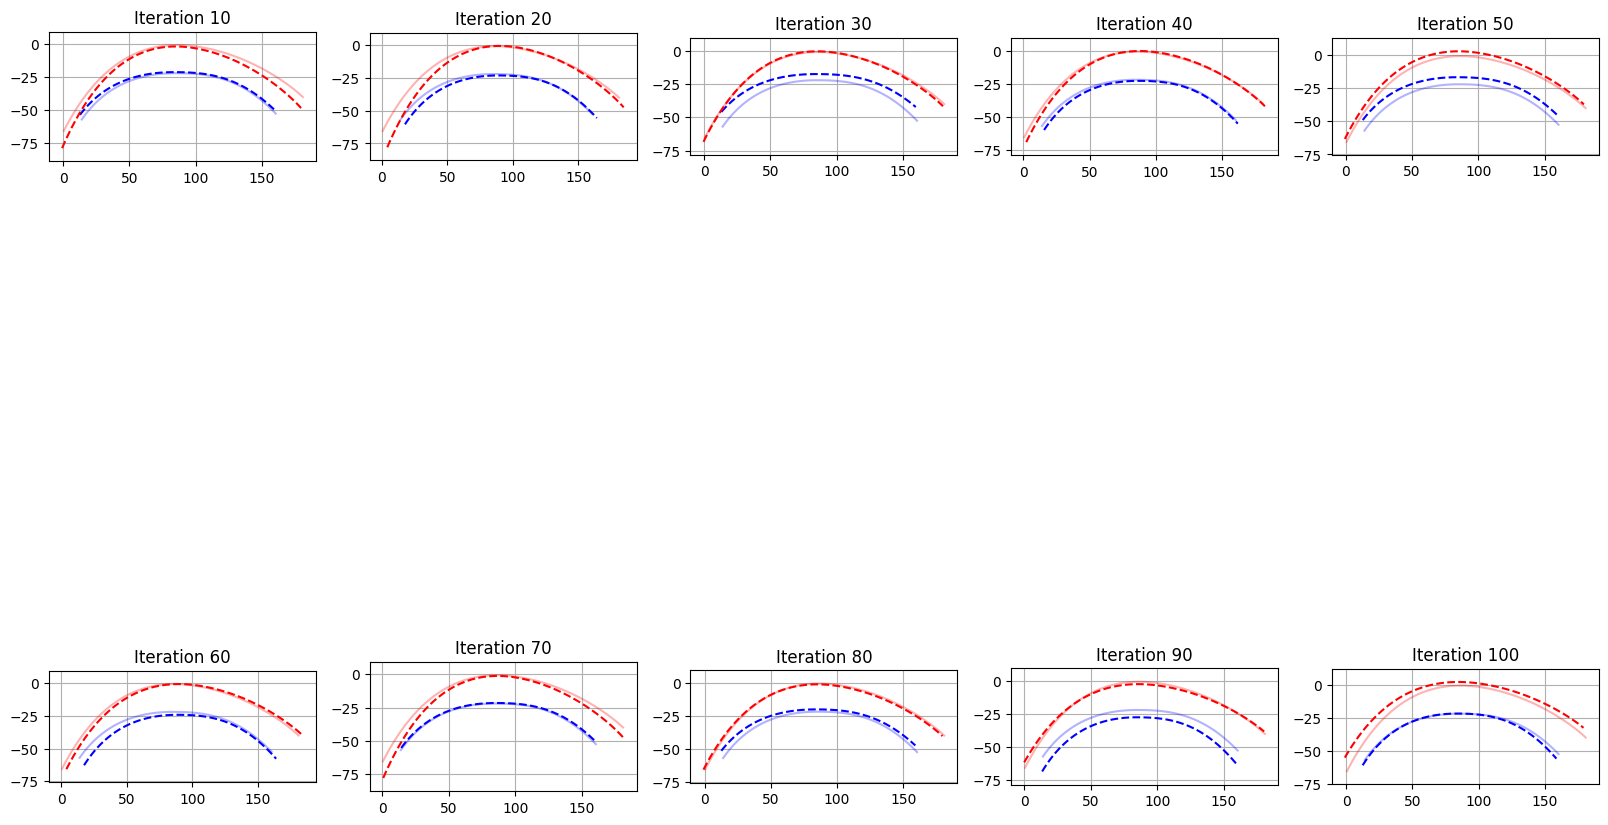

<Figure size 2000x1000 with 0 Axes>

噪声统计信息：
A曲线平均噪声幅度: 3.9651 像素
B曲线平均噪声幅度: 3.0423 像素
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49

/Users/remi/mycode/kigland-research-curve-ab/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5378 - mae: 0.5583 - val_loss: 0.3180 - val_mae: 0.4008
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.2929 - mae: 0.3803 - val_loss: 0.3020 - val_mae: 0.3874
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.3099 - mae: 0.3896 - val_loss: 0.2891 - val_mae: 0.3771
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.2899 - mae: 0.3756 - val_loss: 0.2881 - val_mae: 0.3788
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.2840 - mae: 0.3753 - val_loss: 0.2875 - val_mae: 0.3766
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.2954 - mae: 0.3800 - val_loss: 0.3012 - val_mae: 0.3857
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.2909 - mae: 0.3775 - val_loss: 0.2945 - val_mae: 0.3826
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.2899 - mae: 0.3772 - val_loss: 0.2940 - val_mae: 0.3831
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step

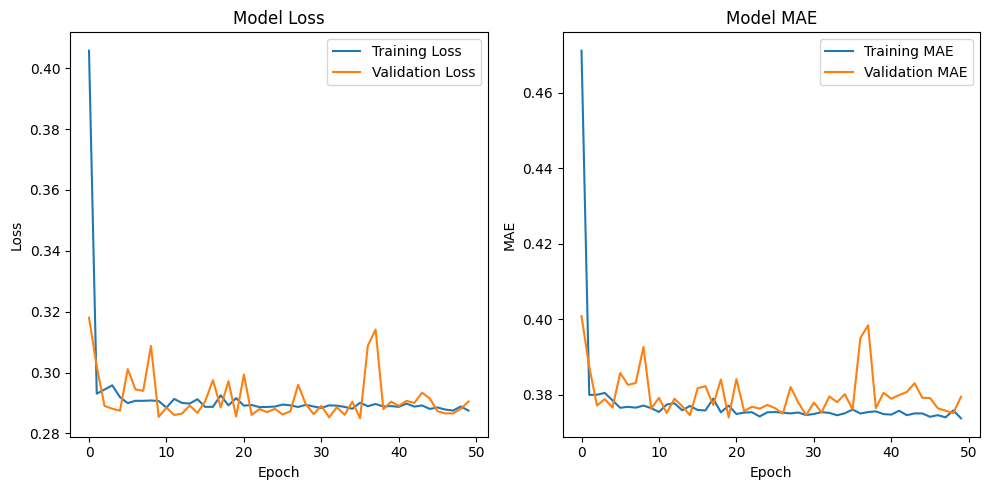

A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
预测值范围: -2.9951334 1.9796143
反标准化后范围: -24.102552 24.991995
警告：预测时第49个点的切向量接近零


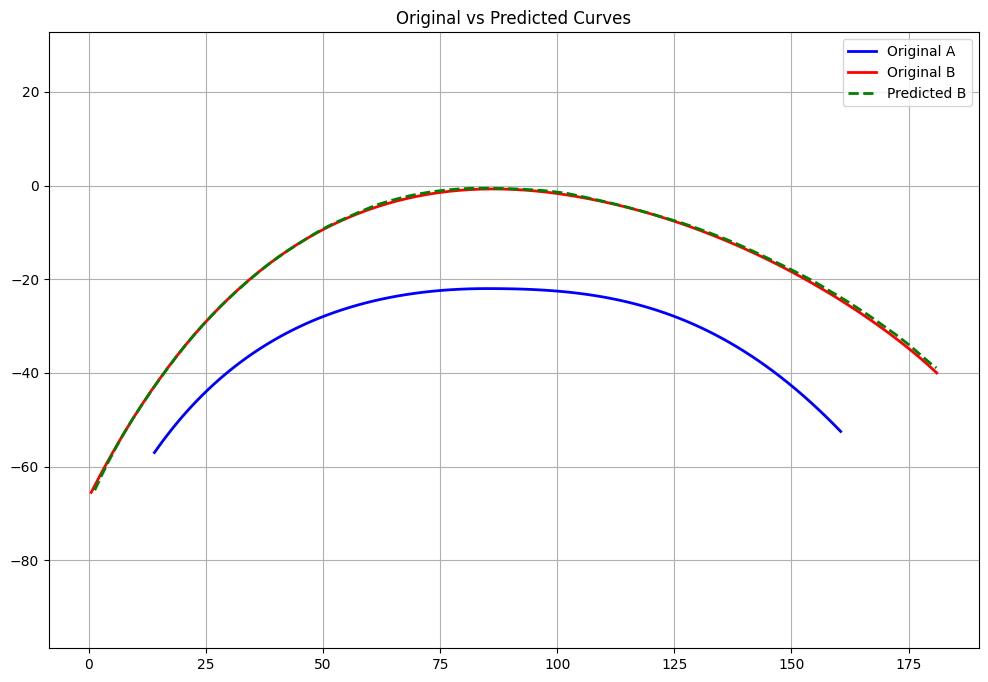

平均预测误差: 0.6067 像素


In [17]:
# 导入必要的包
import numpy as np
import matplotlib.pyplot as plt
from train_model import train_curve_model, predict_B_curve

# 使用示例 SVG 数据
A_d = "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5"
B_d = "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"

# 获取曲线点
A_segments = parse_svg_path(A_d)
B_segments = parse_svg_path(B_d)

A_points = bezier_sample(A_segments)
B_points = bezier_sample(B_segments)

# 为了演示，我们创建20对相似的曲线
A_curves = []
B_curves = []

# 创建一个大图，包含10个子图
plt.figure(figsize=(20, 15))

A_curves = []
B_curves = []
for i in range(100):
    # 整体平移参数
    shift_x = np.random.normal(0, 2.0)  # x方向平移，标准差2.0
    shift_y = np.random.normal(0, 2.0)  # y方向平移，标准差2.0
    
    # 弯折度参数（通过缩放y坐标来改变）
    curve_scale_A = np.random.normal(1.0, 0.1)  # 在1.0附近随机变化，标准差0.1
    curve_scale_B = np.random.normal(1.0, 0.1)
    
    # 对A曲线应用变换
    A_curve = A_points.copy()
    # 在变换前，确保首尾点的连续性
    if np.linalg.norm(A_curve[-1] - A_curve[-2]) < 1e-6:
        # 如果最后两个点太近，稍微调整最后一个点
        direction = A_curve[-1] - A_curve[-2]
        direction = direction / np.linalg.norm(direction)
        A_curve[-1] = A_curve[-2] + direction * 0.1
    
    A_curve[:, 0] += shift_x  # x平移
    A_curve[:, 1] = A_points[:, 1] * curve_scale_A + shift_y  # y缩放和平移
    
    # 对B曲线应用变换
    B_curve = B_points.copy()
    # 在变换前，确保首尾点的连续性
    if np.linalg.norm(B_curve[-1] - B_curve[-2]) < 1e-6:
        direction = B_curve[-1] - B_curve[-2]
        direction = direction / np.linalg.norm(direction)
        B_curve[-1] = B_curve[-2] + direction * 0.1
        
    B_curve[:, 0] += shift_x  # x平移
    B_curve[:, 1] = B_points[:, 1] * curve_scale_B + shift_y  # y缩放和平移
    
    A_curves.append(A_curve)
    B_curves.append(B_curve)
    
    # 每10次迭代画一次图
    if (i + 1) % 10 == 0:
        ax = plt.subplot(2, 5, (i + 1) // 10)
        
        # 画原始曲线（半透明）
        plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', alpha=0.3, label='Original A')
        plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', alpha=0.3, label='Original B')
        
        # 画变换后的曲线
        plt.plot(A_curve[:, 0], -A_curve[:, 1], 'b--', 
                label=f'A {i+1}\n(shift:{shift_x:.1f},{shift_y:.1f})')
        plt.plot(B_curve[:, 0], -B_curve[:, 1], 'r--', 
                label=f'B {i+1}\n(scale:{curve_scale_A:.2f})')
        
        plt.title(f'Iteration {i+1}')
        plt.grid(True)
        if i == 0:  # 只在第一个子图显示图例
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
        # 设置坐标轴比例和范围
        ax.set_aspect('equal', adjustable='box')
        
        # 获取所有点的范围，并添加一些边距
        all_points = np.vstack([A_points, B_points, A_curve, B_curve])
        x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
        y_min, y_max = -all_points[:, 1].max(), -all_points[:, 1].min()
        
        margin = 10
        ax.set_xlim(x_min - margin, x_max + margin)
        ax.set_ylim(y_min - margin, y_max + margin)

plt.figure(figsize=(20, 10))  # 增大图形尺寸
plt.tight_layout()
plt.show()

# 打印一些统计信息
print("噪声统计信息：")
A_noise_avg = np.mean([np.mean(np.sqrt(np.sum((A - A_points)**2, axis=1))) for A in A_curves])
B_noise_avg = np.mean([np.mean(np.sqrt(np.sum((B - B_points)**2, axis=1))) for B in B_curves])
print(f"A曲线平均噪声幅度: {A_noise_avg:.4f} 像素")
print(f"B曲线平均噪声幅度: {B_noise_avg:.4f} 像素")

# 训练模型
model, history, X_scaler, y_scaler = train_curve_model(
    A_curves, 
    B_curves,
    epochs=50,  # 可以根据需要调整
    batch_size=32
)

# 绘制训练历史
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# 使用原始A曲线预测B曲线
predicted_B_points = predict_B_curve(model, A_points, X_scaler, y_scaler)

# 绘制结果
plt.figure(figsize=(12, 8))
plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', label='Original A', linewidth=2)
plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', label='Original B', linewidth=2)
plt.plot(predicted_B_points[:, 0], -predicted_B_points[:, 1], 'g--', 
         label='Predicted B', linewidth=2)
plt.grid(True)
plt.legend()
plt.title('Original vs Predicted Curves')
plt.axis('equal')
plt.show()

# 打印评估指标
test_error = np.mean(np.sqrt(np.sum((predicted_B_points - B_points)**2, axis=1)))
print(f"平均预测误差: {test_error:.4f} 像素")


A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
预测值范围: -2.9951334 1.9796143
反标准化后范围: -24.102552 25.000587
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
预测值范围: -2.9951334 1.9796143
反标准化后范围: -24.102552 24.995243
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
预测值范围: -2.9951334 1.9796143
反标准化后范围: -24.102552 24.99326
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
预测值范围: -2.9951334 1.9796143
反标准化后范围: -24.102552 25.00116
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
预测值范围: -2.9951334 1.9796143
反标准化后范围: -24.102552 24.999907
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.7001810435283815 1.81094121735593
4/4 ━━━━━━━━━━━━━

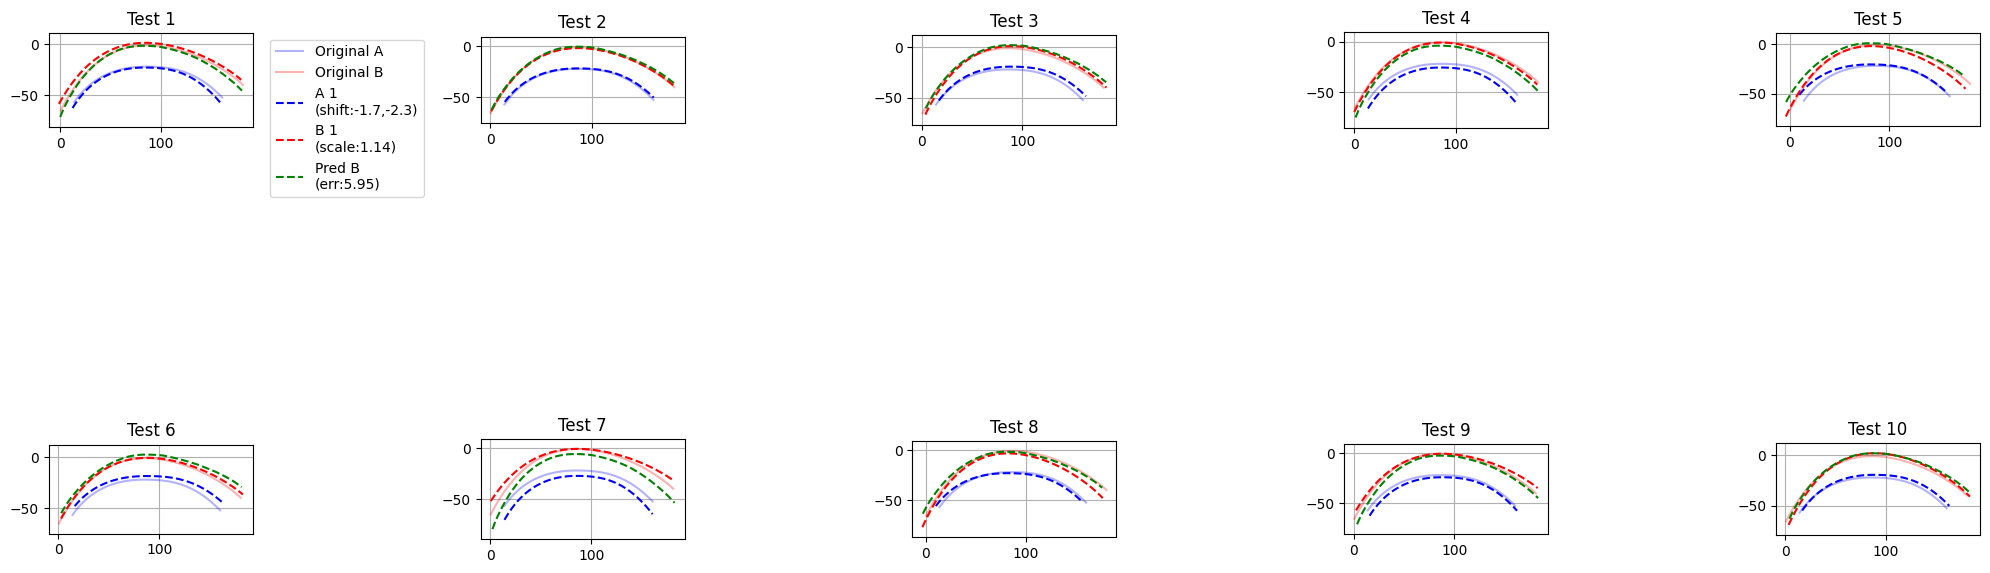


Validation Statistics:
Mean Error: 5.0212 ± 2.8087 pixels
Min Error: 1.8515 pixels
Max Error: 11.9900 pixels


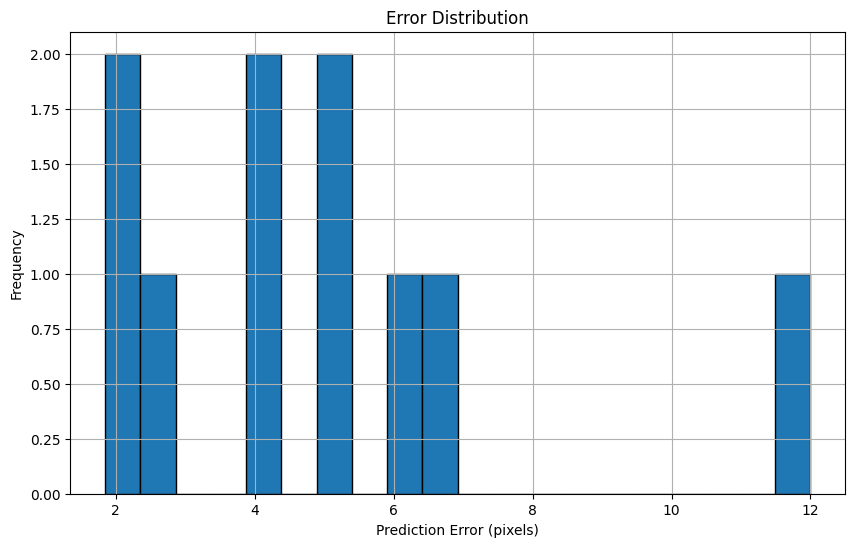

In [18]:
def validate_model_notebook(model, A_points, B_points, X_scaler, y_scaler, n_validations=10):
    """
    Validate model performance with curve transformations
    
    Args:
        model: trained model
        A_points: original A curve points
        B_points: original B curve points
        X_scaler: input data scaler
        y_scaler: output data scaler
        n_validations: number of validation tests
    """
    plt.figure(figsize=(20, 10))
    errors = []
    
    for i in range(n_validations):
        # Translation parameters
        shift_x = np.random.normal(0, 2.0)
        shift_y = np.random.normal(0, 2.0)
        
        # Curve scale parameters
        curve_scale_A = np.random.normal(1.0, 0.1)
        curve_scale_B = np.random.normal(1.0, 0.1)
        
        # Transform A curve
        A_curve = A_points.copy()
        # Ensure continuity of end points
        if np.linalg.norm(A_curve[-1] - A_curve[-2]) < 1e-6:
            direction = A_curve[-1] - A_curve[-2]
            direction = direction / np.linalg.norm(direction)
            A_curve[-1] = A_curve[-2] + direction * 0.1
        
        A_curve[:, 0] += shift_x
        A_curve[:, 1] = A_points[:, 1] * curve_scale_A + shift_y
        
        # Transform B curve
        B_curve = B_points.copy()
        # Ensure continuity of end points
        if np.linalg.norm(B_curve[-1] - B_curve[-2]) < 1e-6:
            direction = B_curve[-1] - B_curve[-2]
            direction = direction / np.linalg.norm(direction)
            B_curve[-1] = B_curve[-2] + direction * 0.1
        
        B_curve[:, 0] += shift_x
        B_curve[:, 1] = B_points[:, 1] * curve_scale_B + shift_y
        
        # Predict B curve
        predicted_B = predict_B_curve(model, A_curve, X_scaler, y_scaler)
        
        # Calculate error
        error = np.mean(np.sqrt(np.sum((predicted_B - B_curve)**2, axis=1)))
        errors.append(error)
        
        # Plot
        ax = plt.subplot(2, 5, i + 1)
        
        # Plot original curves (semi-transparent)
        plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', alpha=0.3, label='Original A')
        plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', alpha=0.3, label='Original B')
        
        # Plot transformed curves
        plt.plot(A_curve[:, 0], -A_curve[:, 1], 'b--', 
                label=f'A {i+1}\n(shift:{shift_x:.1f},{shift_y:.1f})')
        plt.plot(B_curve[:, 0], -B_curve[:, 1], 'r--', 
                label=f'B {i+1}\n(scale:{curve_scale_A:.2f})')
        plt.plot(predicted_B[:, 0], -predicted_B[:, 1], 'g--', 
                label=f'Pred B\n(err:{error:.2f})')
        
        plt.title(f'Test {i+1}')
        plt.grid(True)
        if i == 0:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        ax.set_aspect('equal', adjustable='box')
        
        # Set axis range with margin
        all_points = np.vstack([A_points, B_points, A_curve, B_curve, predicted_B])
        x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
        y_min, y_max = -all_points[:, 1].max(), -all_points[:, 1].min()
        
        margin = 10
        ax.set_xlim(x_min - margin, x_max + margin)
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    plt.show()
    
    # Print validation statistics
    print("\nValidation Statistics:")
    print(f"Mean Error: {np.mean(errors):.4f} ± {np.std(errors):.4f} pixels")
    print(f"Min Error: {np.min(errors):.4f} pixels")
    print(f"Max Error: {np.max(errors):.4f} pixels")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20, edgecolor='black')
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage:
validate_model_notebook(model, A_points, B_points, X_scaler, y_scaler)